In [37]:
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv('Test.csv')

In [39]:
df.shape

(6576, 13)

In [40]:
df.head()

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
0,ID_2MYNQS,1/1/19,PD03,45.289376,11.642394,3.277529,NaN,-0.313361,0.771456,0.000024,0.000075,NaN,14440.02819
1,ID_P4U5WU,1/1/19,TV03,45.836941,12.510362,0.000000,NaN,-0.229512,0.398208,0.000023,0.000120,NaN,14434.04790
2,ID_U4KWPK,1/1/19,X5561,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478
3,ID_QGSNTZ,1/1/19,X5953,45.131947,10.015742,1.928031,NaN,0.132952,0.756917,0.000024,0.000266,NaN,14443.09006
4,ID_GHSZ6K,1/1/19,X6701,45.186329,9.146666,0.000000,NaN,-0.198272,0.678858,0.000023,0.000149,NaN,14440.85840


In [41]:
df['Date'] = pd.to_datetime(df['Date'])
df['Day-Month'] = df['Date'].dt.strftime('%m-%d')
df = df.sort_values(by='Date', ascending=True)
df = df.drop(["ID"], axis=1)
print(f"Size of DataFrame: {df.shape}")

Size of DataFrame: (6576, 13)


/var/folders/wc/g01grcxj65z_db1mfdrp2l140000gn/T/ipykernel_34205/1369760617.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [42]:
df.head()

,ID_Zindi,Date,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,Day-Month
0,ID_2MYNQS,2019-01-01,45.289376,11.642394,3.277529,NaN,-0.313361,0.771456,0.000024,0.000075,NaN,14440.02819,01-01
1,ID_P4U5WU,2019-01-01,45.836941,12.510362,0.000000,NaN,-0.229512,0.398208,0.000023,0.000120,NaN,14434.04790,01-01
2,ID_U4KWPK,2019-01-01,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478,01-01
3,ID_QGSNTZ,2019-01-01,45.131947,10.015742,1.928031,NaN,0.132952,0.756917,0.000024,0.000266,NaN,14443.09006,01-01
4,ID_GHSZ6K,2019-01-01,45.186329,9.146666,0.000000,NaN,-0.198272,0.678858,0.000023,0.000149,NaN,14440.85840,01-01


In [43]:
nan_counts = df.isna().sum()

# Print the number of NaN values alongside the column names
for column, count in nan_counts.items():
    print(f'Column: {column}, NaN Count: {count}')

Column: ID_Zindi, NaN Count: 0
Column: Date, NaN Count: 0
Column: LAT, NaN Count: 0
Column: LON, NaN Count: 0
Column: Precipitation, NaN Count: 0
Column: LST, NaN Count: 2981
Column: AAI, NaN Count: 868
Column: CloudFraction, NaN Count: 868
Column: NO2_strat, NaN Count: 868
Column: NO2_total, NaN Count: 868
Column: NO2_trop, NaN Count: 2578
Column: TropopausePressure, NaN Count: 868
Column: Day-Month, NaN Count: 0


In [44]:
date_counts = df['Date'].value_counts().sort_index()

print(date_counts)

Date
2019-01-01    6
2019-01-02    6
2019-01-03    6
2019-01-04    6
2019-01-05    6
             ..
2021-12-27    6
2021-12-28    6
2021-12-29    6
2021-12-30    6
2021-12-31    6
Name: count, Length: 1096, dtype: int64


In [45]:
unique_locations = df[['LAT', 'LON']].drop_duplicates()
number_of_unique_locations = unique_locations.shape[0]

print(f"Number of unique locations: {number_of_unique_locations}")

Number of unique locations: 6


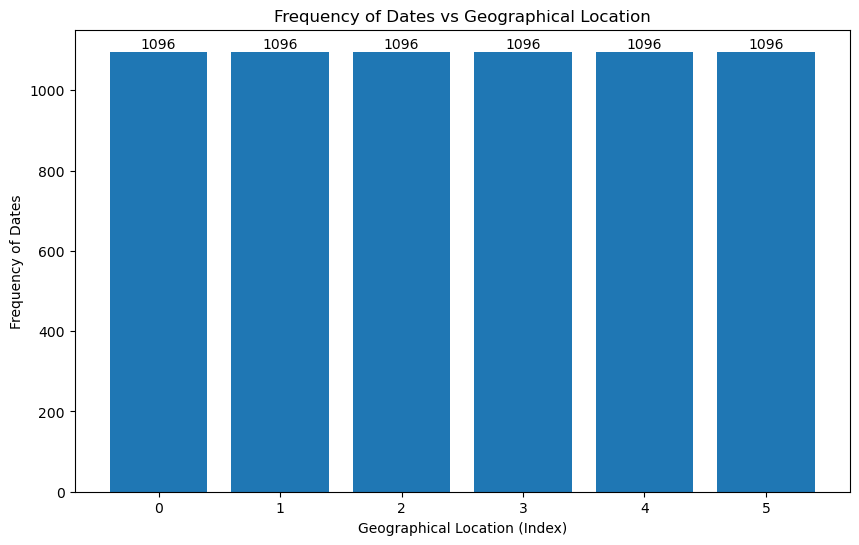

In [46]:
# Group by 'Latitude' and 'Longitude', and count the number of dates for each group
location_date_count = df.groupby(['LAT', 'LON'])['Date'].count().reset_index(name='DateCount')

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(range(location_date_count.shape[0]), location_date_count['DateCount'])
plt.xlabel('Geographical Location (Index)')
plt.ylabel('Frequency of Dates')
plt.title('Frequency of Dates vs Geographical Location')

# Adding the exact frequency value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

### Imputer

In [47]:
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

from tqdm import tqdm

In [48]:
kmeans = KMeans(n_clusters=6, random_state=42)
df['Location_Cluster'] = kmeans.fit_predict(df[['LAT', 'LON']])

In [49]:
# Initialize a list to store imputed DataFrames
imputed_dfs = []

# Group the DataFrame by clusters
clustered_groups = df.groupby('Location_Cluster')

for cluster, group in tqdm(clustered_groups):

    # Reset index for KNN Imputer
    group = group.reset_index(drop=True)
    
    # Prepare data for KNN Imputer
    imputer_data = group[['Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure',
       'Day-Month']].copy()
    
    # Convert 'Day-Month' to numerical format for KNN
    imputer_data['Day-Month'] = imputer_data['Day-Month'].apply(lambda x: int(x.replace('-', '')))
    
    # Apply KNN Imputer
    imputer = KNNImputer(n_neighbors=7)  # Adjust n_neighbors as needed
    imputed_values = imputer.fit_transform(imputer_data)
    
    # Replace the imputed columns back to the group DataFrame
    # Adjusting the slice to include all columns
    group[['Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure',
       'Day-Month']] = imputed_values  # Note: Ensure that the columns match in length
    
    # Append the imputed group DataFrame to the list
    imputed_dfs.append(group)

# Concatenate all the imputed DataFrames back together
df_imputed = pd.concat(imputed_dfs, axis=0).sort_index()

100%|██████████| 6/6 [00:00<00:00, 25.30it/s]


In [50]:
print(df_imputed['Location_Cluster'].value_counts())
df_imputed.head()

Location_Cluster
0    1096
4    1096
5    1096
3    1096
2    1096
1    1096
Name: count, dtype: int64


,ID_Zindi,Date,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,Day-Month,Location_Cluster
0,ID_U4KWPK,2019-01-01,45.582894,8.842165,0.000000,282.980000,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478,101.0,0
0,ID_NKPFFW,2019-01-01,45.151743,10.781408,4.023135,280.917143,0.044013,0.891932,0.000024,0.000292,0.000201,14441.18578,101.0,4
0,ID_GHSZ6K,2019-01-01,45.186329,9.146666,0.000000,281.394286,-0.198272,0.678858,0.000023,0.000149,0.000171,14440.85840,101.0,5
0,ID_P4U5WU,2019-01-01,45.836941,12.510362,0.000000,283.374286,-0.229512,0.398208,0.000023,0.000120,0.000119,14434.04790,101.0,3
0,ID_QGSNTZ,2019-01-01,45.131947,10.015742,1.928031,281.562857,0.132952,0.756917,0.000024,0.000266,0.000251,14443.09006,101.0,2


In [29]:
# # Drop the 'Day-Month' column as it's no longer needed
df_clean = df_imputed.drop(columns=['Day-Month', 'Location_Cluster'])

df_clean.head()

,ID_Zindi,Date,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
0,ID_U4KWPK,2019-01-01,45.582894,8.842165,0.000000,282.980000,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478
0,ID_NKPFFW,2019-01-01,45.151743,10.781408,4.023135,280.917143,0.044013,0.891932,0.000024,0.000292,0.000201,14441.18578
0,ID_GHSZ6K,2019-01-01,45.186329,9.146666,0.000000,281.394286,-0.198272,0.678858,0.000023,0.000149,0.000171,14440.85840
0,ID_P4U5WU,2019-01-01,45.836941,12.510362,0.000000,283.374286,-0.229512,0.398208,0.000023,0.000120,0.000119,14434.04790
0,ID_QGSNTZ,2019-01-01,45.131947,10.015742,1.928031,281.562857,0.132952,0.756917,0.000024,0.000266,0.000251,14443.09006


In [31]:
nan_counts = df_clean.isna().sum()

# Print the number of NaN values alongside the column names
for column, count in nan_counts.items():
    print(f'Column: {column}, NaN Count: {count}')

Column: ID_Zindi, NaN Count: 0
Column: Date, NaN Count: 0
Column: LAT, NaN Count: 0
Column: LON, NaN Count: 0
Column: Precipitation, NaN Count: 0
Column: LST, NaN Count: 0
Column: AAI, NaN Count: 0
Column: CloudFraction, NaN Count: 0
Column: NO2_strat, NaN Count: 0
Column: NO2_total, NaN Count: 0
Column: NO2_trop, NaN Count: 0
Column: TropopausePressure, NaN Count: 0


Number of unique geographical locations with 1096 date values: 6


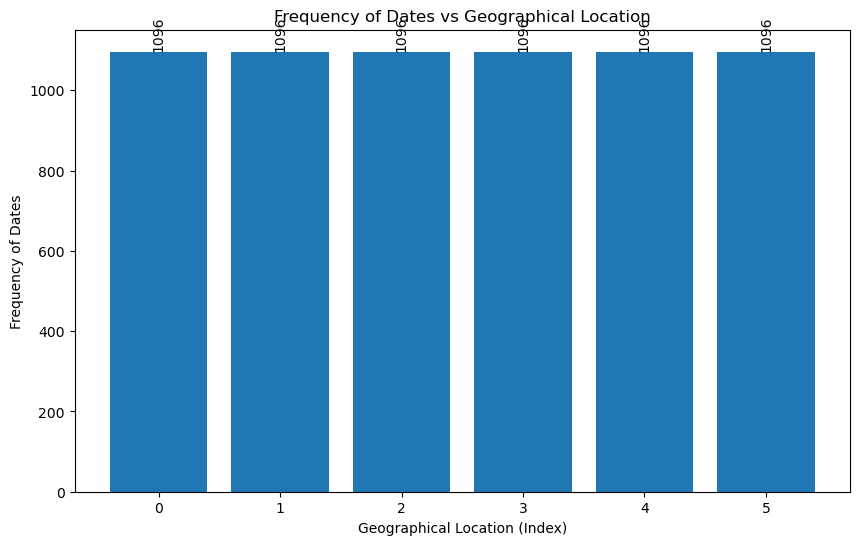

In [32]:
location_date_count = df.groupby(['LAT', 'LON'])['Date'].count().reset_index(name='DateCount')

locations_with_1096_dates = location_date_count[location_date_count['DateCount'] >= 1096]

# Count the number of unique geographical locations with 1096 date values
number_of_locations_with_1096_dates = locations_with_1096_dates.shape[0]

print(f"Number of unique geographical locations with 1096 date values: {number_of_locations_with_1096_dates}")

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(range(location_date_count.shape[0]), location_date_count['DateCount'])
plt.xlabel('Geographical Location (Index)')
plt.ylabel('Frequency of Dates')
plt.title('Frequency of Dates vs Geographical Location')

# Adding the exact frequency value on top of each bar, oriented vertically
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', rotation=90)

plt.show()

In [33]:
df_clean.to_csv('Test_Cleaned_KNN.csv', index=False)

### add -15 days 

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Test_Data_Delete.csv')

In [3]:
prior_df = pd.read_csv('Train_Data_Delete.csv')

In [7]:
df.head(10)

,ID_Zindi,Date,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,Day-Month,Location_Cluster
0,ID_U4KWPK,2019-01-01,45.582894,8.842165,0.000000,282.980000,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.424780,101.0,0
1,ID_AWKIOR,2020-01-01,45.582894,8.842165,0.000000,282.320000,-1.337268,0.015015,0.000028,0.000163,0.000135,14429.611350,101.0,0
2,ID_YTQALR,2021-01-01,45.582894,8.842165,13.127209,282.425714,-0.962440,0.145874,0.000027,0.000156,0.000146,18718.199337,101.0,0
3,ID_RMBWWV,2019-01-02,45.582894,8.842165,0.000000,283.600000,-0.750231,0.000000,0.000032,0.000074,0.000042,19273.070910,102.0,0
4,ID_4VRJNL,2020-01-02,45.582894,8.842165,0.000000,281.180000,-1.248286,0.085552,0.000025,0.000257,0.000231,14430.630220,102.0,0
5,ID_MGRFVN,2021-01-02,45.582894,8.842165,26.254417,282.620000,-0.974825,0.160864,0.000028,0.000135,0.000111,19974.185116,102.0,0
6,ID_SQCZ4B,2019-01-03,45.582894,8.842165,0.000000,280.520000,-0.816473,0.000000,0.000028,0.000266,0.000238,22180.170040,103.0,0
7,ID_84N6H3,2020-01-03,45.582894,8.842165,4.528032,282.354286,-1.201153,0.256977,0.000025,0.000181,0.000170,19669.909461,103.0,0
8,ID_4V3TLN,2021-01-03,45.582894,8.842165,6.563604,288.851429,-1.326144,0.766857,0.000026,0.000108,0.000073,24184.199990,103.0,0
9,ID_HR1N35,2019-01-04,45.582894,8.842165,0.000000,282.248571,-1.426628,0.160008,0.000019,0.000293,0.000281,16711.563830,104.0,0


In [8]:
prior_df.head(10)

,Date,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,Day-Month,Location_Cluster
0,2019-01-01,45.330361,9.414645,0.000000,281.845714,0.313861,0.671681,0.000023,0.000175,0.000174,14443.24936,29.750,101.0,0
1,2019-01-01,45.716300,10.044766,0.000000,279.640000,-0.612119,0.089885,0.000023,0.000147,0.000170,14420.63506,19.175,101.0,5
2,2019-01-01,45.281956,8.988563,0.000000,281.222857,0.516055,0.704873,0.000023,0.000140,0.000120,14437.64238,31.175,101.0,3
3,2019-01-01,45.160568,10.795564,4.023135,288.842857,0.012465,0.880900,0.000024,0.000269,0.000106,14441.89312,27.650,101.0,2
4,2019-01-01,45.038758,11.790152,1.274564,305.742857,-0.176178,0.747464,0.000024,0.000116,0.000066,14438.79037,58.000,101.0,1
5,2019-01-01,45.396195,9.282700,0.000000,281.514286,0.471113,0.640860,0.000023,0.000200,0.000262,14441.03373,41.375,101.0,6
6,2019-01-01,45.601585,11.903551,0.000000,291.540000,0.230527,0.559117,0.000024,0.000117,0.000084,14440.82126,31.000,101.0,7
7,2019-01-01,45.428424,12.312930,0.650355,299.520000,0.208678,0.812696,0.000024,0.000117,0.000090,14437.71015,35.000,101.0,8
8,2019-01-01,45.104075,11.553241,1.200467,297.057143,-0.010442,0.920054,0.000024,0.000124,0.000077,14440.83831,30.000,101.0,9
9,2019-01-01,45.671721,12.237807,0.000000,294.734286,0.188599,0.818422,0.000024,0.000135,0.000076,14436.70176,38.000,101.0,4


In [9]:
df = df.sort_values(by=['Date', 'Location_Cluster'], ascending=[True, True])
prior_df = prior_df.sort_values(by=['Date', 'Location_Cluster'], ascending=[True, True])

In [10]:
df.head(10)

,ID_Zindi,Date,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,Day-Month,Location_Cluster
0,ID_U4KWPK,2019-01-01,45.582894,8.842165,0.000000,282.980000,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478,101.0,0
1096,ID_2MYNQS,2019-01-01,45.289376,11.642394,3.277529,282.220000,-0.313361,0.771456,0.000024,0.000075,0.000159,14440.02819,101.0,1
2192,ID_QGSNTZ,2019-01-01,45.131947,10.015742,1.928031,281.562857,0.132952,0.756917,0.000024,0.000266,0.000251,14443.09006,101.0,2
3288,ID_P4U5WU,2019-01-01,45.836941,12.510362,0.000000,283.374286,-0.229512,0.398208,0.000023,0.000120,0.000119,14434.04790,101.0,3
4384,ID_NKPFFW,2019-01-01,45.151743,10.781408,4.023135,280.917143,0.044013,0.891932,0.000024,0.000292,0.000201,14441.18578,101.0,4
5480,ID_GHSZ6K,2019-01-01,45.186329,9.146666,0.000000,281.394286,-0.198272,0.678858,0.000023,0.000149,0.000171,14440.85840,101.0,5
3,ID_RMBWWV,2019-01-02,45.582894,8.842165,0.000000,283.600000,-0.750231,0.000000,0.000032,0.000074,0.000042,19273.07091,102.0,0
1099,ID_Z9ICW9,2019-01-02,45.289376,11.642394,0.000000,281.080000,-0.177263,0.166926,0.000033,0.000128,0.000057,20775.67062,102.0,1
2195,ID_8JASJD,2019-01-02,45.131947,10.015742,0.000000,281.988571,-0.626818,0.391763,0.000034,0.000223,0.000162,19330.30774,102.0,2
3291,ID_H2YFI6,2019-01-02,45.836941,12.510362,0.000000,282.360000,-0.606076,0.045993,0.000032,0.000064,0.000032,20740.12494,102.0,3


In [11]:
df.shape

(6576, 14)

In [12]:
prior_df.shape

(82051, 14)

In [13]:
test = pd.concat([prior_df, df], ignore_index=True)

In [17]:
test.iloc[82011:82061].head(50)

,Date,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,Day-Month,Location_Cluster,ID_Zindi
82011,2021-12-31,45.249544,10.299119,0.000000,282.077143,-1.037367,0.359459,0.000031,0.000555,0.000161,13064.80943,34.475,1231.0,5,NaN
82012,2021-12-31,45.539529,10.231786,0.000000,284.400000,-0.297831,0.004217,0.000031,0.000176,0.000145,13059.45932,53.075,1231.0,5,NaN
82013,2021-12-31,45.283977,9.863398,0.000000,282.077143,-1.098018,0.297598,0.000032,0.000384,0.000161,13065.00600,25.900,1231.0,5,NaN
82014,2021-12-31,45.278488,10.006202,0.000000,282.077143,-1.089471,0.344780,0.000032,0.000407,0.000161,13065.05908,20.175,1231.0,5,NaN
82015,2021-12-31,45.513039,10.191942,0.000000,284.580000,-0.384699,0.010460,0.000031,0.000200,0.000168,13064.37568,39.100,1231.0,5,NaN
82016,2021-12-31,45.542648,10.211205,0.000000,284.760000,-0.394590,0.018610,0.000031,0.000176,0.000145,13061.32433,75.175,1231.0,5,NaN
82017,2021-12-31,45.508667,10.256370,0.000000,283.320000,-0.258359,0.000000,0.000031,0.000218,0.000186,13062.94145,62.600,1231.0,5,NaN
82018,2021-12-31,45.150469,9.930596,0.000000,282.077143,-1.140941,0.336822,0.000032,0.000463,0.000161,13064.83937,42.250,1231.0,5,NaN
82019,2021-12-31,45.627357,9.026401,0.000000,283.540000,-0.281536,0.000673,0.000031,0.000175,0.000144,13056.43707,49.850,1231.0,6,NaN
82020,2021-12-31,45.730837,9.125734,0.000000,285.740000,-0.232540,0.000000,0.000031,0.000164,0.000133,13054.63727,44.750,1231.0,6,NaN
